# Project 2 -- Clustering

## Amanda Everitt

In [68]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {return false;}

<IPython.core.display.Javascript object>

In [69]:
from clusters import algs
import numpy as np
import matplotlib.pyplot as plt
import umap.umap_ as umap
import itertools
import pandas as pd
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
np.random.seed(10)

1. Explain the distance metric you utilized to calculate the similarity/dissimilarity between small molecules.
> Due to the binary nature of the small molecules SMILE scores, I dominantly used the jaccard (or tonimoto coefficient). This is implemented as the intersection where two small molecules both have an "on" bit divided by the union of all occuring "on" bits. To prevent the scale from being prohibitively small, the coefficient is scaled by a factor of 10 (arbitrary here, and can be changed by user). For testing purposes, the algorithm can also do a standard euclidean distance. 

2. Use a dimensionality reduction algorithm (PCA, t-SNE, UMAP, etc) to generate a 2D visualization of the small molecule dataset. Each point should represent a single molecule. (Note: you may have to plot a subset of your data, depending on which dimensionality reduction algorithm you choose.)
> Plotted below is a UMAP of all small molecules in the dataset (dense bit representation), using the jaccard as the distance metric. 

In [70]:
#read all scores in as a list
ligand_dict = algs.read_in_ligands("ligand_information.csv")
data = []
for i,j in ligand_dict.items():
    a = ligand_dict[i].denseBits
    data.append(a)

#calculate components using umap function
fit = umap.UMAP(metric = "jaccard")
u = fit.fit_transform(data)

/usr/local/lib/python3.8/site-packages/umap/umap_.py:1760: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


Text(0, 0.5, 'UMAP 2')

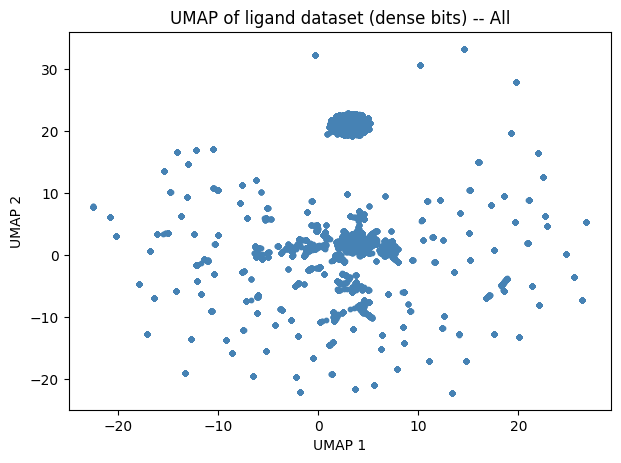

In [71]:
#plt.figure(figsize =(10, 5)) 
#plt.subplot(1, 2, 1)
plt.scatter(u[:,0], u[:,1], c = "steelblue", s = 10)
plt.title("UMAP of ligand dataset (dense bits) -- All")
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

3. Cluster the small molecules using your implementation of a partitioning clustering algorithm. Visualize this clustering by coloring clusters on the 2D visualization generated in question 2.

> I've implemented quite a simple partioning algorithm and because of this, it has a few large limitations. While the script runs correctly, its just not robust enough to handle the input data like we've been given. Rather than implement k++, I tried to explore which limitation was causing such a poor performance. Below, I generated different labels based on the paramenters I let the user change. For the rest of the assignment, I go forward with the best looking visual one ( ). I talk more about the exact design in Q4, but the main limitations in my algorithm are:

> 1. Seed choice has large effect on initialization since I used a random seed selection. This can be changed by the "seed" parameter in cluster(). 
> 2. This also means centroids can be unfortunately initilized to random outlier points, and its very hard to come back from that. No datapoints will be updated to this cluster and it will remain empty. Because of this, I added the parameter "allow_reinit". When a cluster reaches a size of zero, it will select a new centroid to try. (In a real dataset this would increase the computational time prohibitively, but here its seems to help quite a bit). 
> 3. New centroids are updated to be the mean of all current data points in that cluster. This works with euclidean/continous data, but clearly for binary jaccard coefficients this isn't as straight-forward. I implemented a thresholding system where values greater than 0.5 are set to one and all others are zeros. However, this 0.5 threshold is arbitrary so I allowed the user to control this using the "mean_threshold" parameter. 

In [94]:
ligand_subset = dict(itertools.islice(ligand_dict.items(), 100)) #create a small subset for testing.  
data_sub = []
for i,j in ligand_subset.items():
    a = ligand_subset[i].denseBits
    data_sub.append(a)
u_sub = fit.fit_transform(data_sub)

/usr/local/lib/python3.8/site-packages/umap/umap_.py:1760: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


> Hi guys, so my apologies. I spent too much time troubleshooting my silhouette score function and there's no way this notebook will knit in time. I had been running this on subsets and really underestimated how long it would actually take to run on 1000+ ligands. That O(n^2) complexity is biting me right now amiright. :/  Going forward, I'm just using this subset of 50 in this notebook. 

In [95]:
# euclidean  re-init + seed
result = algs.PartitionClustering(ligand_subset, distance_metric = "euclidean", allow_reinit=False,  
                                desired_k = 3).cluster(seed=3, max_iter = 50)
var1 = result.labels.values()

result = algs.PartitionClustering(ligand_subset, distance_metric = "euclidean", allow_reinit=True,  
                                desired_k = 3).cluster(seed=3, max_iter = 50)
var2 = result.labels.values()

result = algs.PartitionClustering(ligand_subset, distance_metric = "euclidean", allow_reinit=True,  
                                desired_k = 3).cluster(seed=1234, max_iter = 50)
var3 = result.labels.values()
print("close")

#jaccard  re-init + seed

result = algs.PartitionClustering(ligand_subset, distance_metric = "jaccard", allow_reinit=False, 
                                desired_k = 3, mean_threshold=0.5).cluster(seed = 3, max_iter = 50)
var4 = result.labels.values()

result = algs.PartitionClustering(ligand_subset, distance_metric = "jaccard", allow_reinit=True, 
                                desired_k = 3, mean_threshold=0.5).cluster(seed = 3, max_iter = 50)
var5 = result.labels.values()

result = algs.PartitionClustering(ligand_subset, distance_metric = "jaccard", allow_reinit=True, 
                                desired_k = 3, mean_threshold=0.5).cluster(seed = 1234, max_iter = 50)
var6 = result.labels.values()
print("closer")

# jaccard mean thres. 
result = algs.PartitionClustering(ligand_subset, distance_metric = "jaccard", allow_reinit=True, 
                                desired_k = 3, mean_threshold=0.2).cluster(seed = 3, max_iter = 50)
var7 = result.labels.values()

result = algs.PartitionClustering(ligand_subset, distance_metric = "jaccard", allow_reinit=True, 
                                desired_k = 3, mean_threshold=0.7).cluster(seed = 3, max_iter = 50)
var8 = result.labels.values()
print("done")

close
closer
done


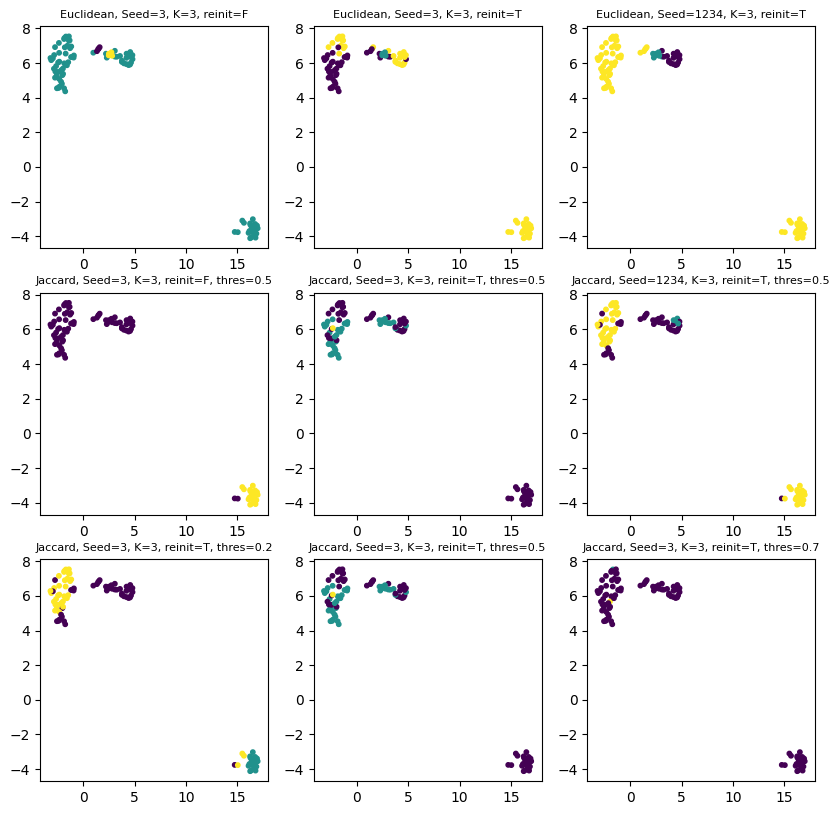

In [96]:
plt.figure(figsize =(10, 10)) 

plt.subplot(3, 3, 1)
plt.scatter(u_sub[:,0], u_sub[:,1], c = list(var1), s = 10)
plt.title("Euclidean, Seed=3, K=3, reinit=F", fontsize=8)
plt.subplot(3, 3, 2)
plt.scatter(u_sub[:,0], u_sub[:,1], c = list(var2), s = 10)
plt.title("Euclidean, Seed=3, K=3, reinit=T", fontsize=8)
plt.subplot(3, 3, 3)
plt.scatter(u_sub[:,0], u_sub[:,1], c = list(var3), s = 10)
plt.title("Euclidean, Seed=1234, K=3, reinit=T", fontsize=8)

plt.subplot(3, 3, 4)
plt.scatter(u_sub[:,0], u_sub[:,1], c = list(var4), s = 10)
plt.title("Jaccard, Seed=3, K=3, reinit=F, thres=0.5", fontsize=8)
plt.subplot(3, 3, 5)
plt.scatter(u_sub[:,0], u_sub[:,1], c = list(var5), s = 10)
plt.title("Jaccard, Seed=3, K=3, reinit=T, thres=0.5", fontsize=8)
plt.subplot(3, 3, 6)
plt.scatter(u_sub[:,0], u_sub[:,1], c = list(var6), s = 10)
plt.title("Jaccard, Seed=1234, K=3, reinit=T, thres=0.5", fontsize=8)

plt.subplot(3, 3, 7)
plt.scatter(u_sub[:,0], u_sub[:,1], c = list(var7), s = 10)
plt.title("Jaccard, Seed=3, K=3, reinit=T, thres=0.2", fontsize=8)
plt.subplot(3, 3, 8)
plt.scatter(u_sub[:,0], u_sub[:,1], c = list(var5), s = 10)
plt.title("Jaccard, Seed=3, K=3, reinit=T, thres=0.5", fontsize=8)
plt.subplot(3, 3, 9)
plt.scatter(u_sub[:,0], u_sub[:,1], c = list(var8), s = 10)
plt.title("Jaccard, Seed=3, K=3, reinit=T, thres=0.7", fontsize=8)

plt.show()


> Take-aways: 
> Euclidean sucks for this type of data as expected. Seeds will slightly change results as expected. Re-initializing the centroids is the best way to ensure the proper number of clusters is reached and they're not ouliers. Lowering the threshold seems to help -- increasing it hurts. 

In [97]:
#Final selection
#actual_ligand_subset = dict(itertools.islice(ligand_dict.items(), 1000))
actual_ligand_subset = ligand_subset
amanda_pc_clusters = algs.PartitionClustering(ligand_subset, distance_metric = "jaccard", allow_reinit=True, 
                                desired_k = 3, mean_threshold=0.2).cluster(seed = 3, max_iter = 50)
amanda_pc_clusters_pmat = algs.make_distance_matrix(amanda_pc_clusters)
a = amanda_pc_clusters.labels
pc_cluster_assignments = a.values()

#equivalent to bottom left plot

4. Explain your choice of partitioning clustering algorithm. Is it sensitive to initialization conditions? How do you select the number of clusters?

> For my partitioning algorithm, I employed the naiive k-means clustering. The centroids are initialized using the Forgy method which randomly chooses data points as initial centroids. Using a jaccard distance metric, each data point is then classified as a cluster member. For every iteration, the centroid is updated to the mean of the cluster points. In euclidean distance, this would represent the arithmetic mean of all cluster points. Using jaccard distance, the mean is taken and values < 0.5 are set to 0 and values >= 0.5 are set to 1. This is an area that would require significant improvements in future versions as a 0.5 cut-off is arbitrary and likely too high a value given the data is zero-inflated. Its important to note, using both distance metrics my centroids may not represent a real value that occurs in the data or nature. This is another limitation that would need improvement in future versions. Either mediodds or k-means ++ could help this aspect. 
Finally, the program will terminate when either the number of iterations the user requested is reached or the cluster assignmenents stop changing between iterations. 

> My algorithm is very sensitive to initialization conditions. Particularly, randomly selecting initial centroids will highly vary from one run to the next. Its important to set a seed or take the average results over many different seeds. Additionally, if a data point is equidistance from two centroids, the first will arbitrarily be chosen which is also sensitive to initialization and seed choice. 

> The user can select the number of clusters a priori. For example, in the UMAP above it is clear there should be 3-4 main clusters. The user could also generate an varying silhouette width plots for varying values of k and select which looks the most ideal in terms of score, fluctuations, and cluster uniformity. This is used as an alternative to elbow plots. 
> https://vitalflux.com/elbow-method-silhouette-score-which-better/

In [98]:
def amanda_plot_silhouette(silhouette_samples, labels, total, mytitle):
    #Makeshift adaptation of yellowbrick Silhouette Visualizer
    
    #test:
    #silhouette_samples = [0.9, 0.95, 0.9, 0.9, 0.7, 0.7, 0.6] 
    #labels = [1, 1, 1, 1, 2, 2, 3]
    #total = 0.6
    #amanda_plot_silhouette(silhouette_samples, labels, 0.5, "hello " + str(1))
    
    plt.figure() 
    fig, ax = plt.subplots() 
    
    y_tick_pos_ = []
    y_lower = 10 
    
    clusters = list(set(labels))
    clusters.sort()
    
    for cluster in clusters:
        index_list = list(filter(lambda x: labels[x] == cluster, range(len(labels)))) 
        values = np.array([silhouette_samples[i] for i in index_list])
        values.sort()
        size = values.shape[0]
        y_upper = y_lower + size

        color = "steelblue"
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            values,
            facecolor=color,
            edgecolor=color,
            alpha=0.5,
        )
        
        y_tick_pos_.append(y_lower + 0.5 * size)
        y_lower = y_upper + 1
    
    ax.axvline(
            x=total, 
            color="red",
            linestyle="--",
            label="Average Silhouette Score",
        )
    
    ax.set_xlabel("silhouette coefficient values")
    ax.set_ylabel("cluster label")
    
    ax.set_yticks(y_tick_pos_)
    ax.set_yticklabels(str(idx) for idx in range(len(clusters)))
    ax.set_title( mytitle) #"Silhoutte Plot: K=")
    #ax.set_ylim([0, len(labels) + (len(clusters) + 1) * 10])
    plt.show()

> As an example, here are the different silhouette plots for varying levels of k. However, this is clearly wrong. For small values and euclidean distances, the silhoutte functions seems to work and gives results similar to scipy output. However, when I used it on the larger dataset with a jaccard based proximity matrix it started giving negative values and I didn't have enough time find the bug as to why.  whomp whomp

<Figure size 700x500 with 0 Axes>

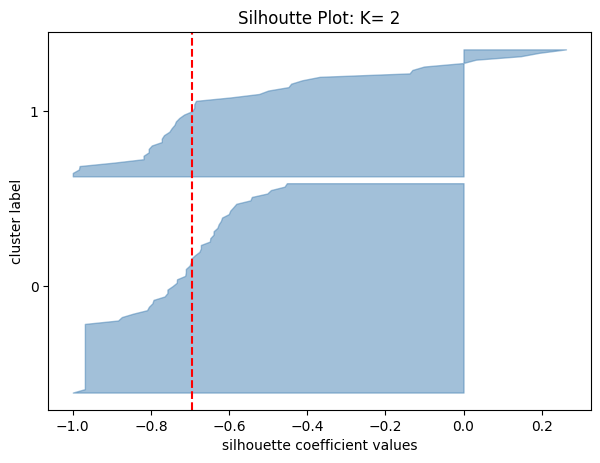

<Figure size 700x500 with 0 Axes>

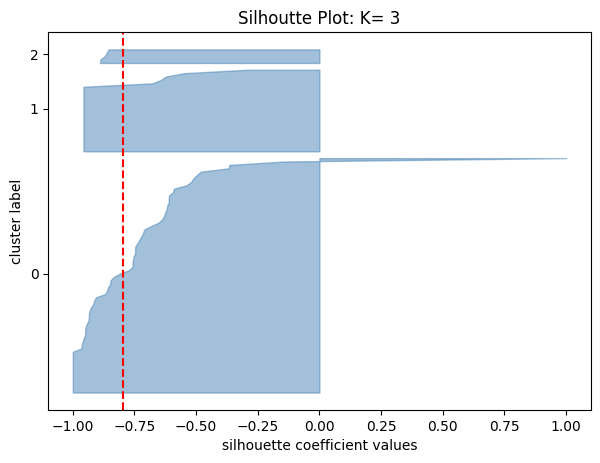

In [99]:
pc_init = algs.PartitionClustering(ligand_subset, 
                                   distance_metric = "jaccard", 
                                   allow_reinit=True, 
                                   desired_k = 5, mean_threshold=0.2)
p_mat = algs.make_distance_matrix(pc_init) #distance matrix based on pc_init settings

for k in range(2,4):
    result = algs.PartitionClustering(ligand_subset, 
                                   distance_metric = "jaccard", 
                                   allow_reinit=True, 
                                   desired_k = k, mean_threshold=0.2).cluster(seed = 3, max_iter = 10)
    labels = np.fromiter(result.labels.values(), dtype=int)
    samples_score, total_score = algs.silhouette_score(p_mat , labels)
    amanda_plot_silhouette(samples_score, labels, total_score, "Silhoutte Plot: K= "+str(k))

5. Cluster the small molecules using your implementation of a hierarchical clustering algorithm. Visualize this clustering in the same way as question 3.

In [105]:
amanda_hc_clusters = algs.HierarchicalClustering(ligand_subset, 
                                           distance_metric = "jaccard", 
                                           desired_k = 3).cluster()
a = amanda_hc_clusters.labels
hc_cluster_assignments = a.values()
print("done")

done


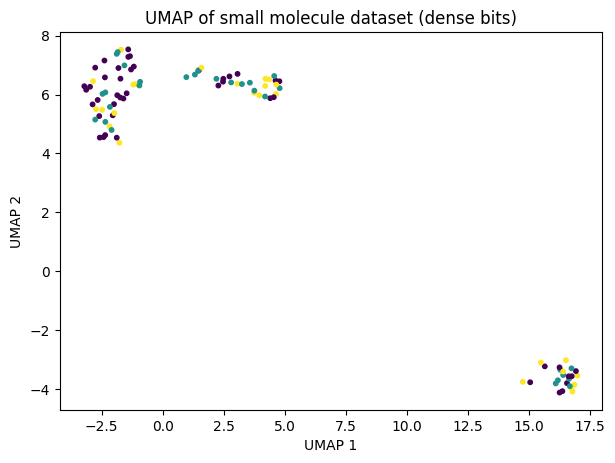

In [106]:
plt.figure()
plt.scatter(u_sub[:,0], u_sub[:,1], c = list(hc_cluster_assignments), s = 10)
plt.title("UMAP of small molecule dataset (dense bits)")
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

#lol 

6. Explain your choice of hierarchical clustering algorithm. Is it sensitive to initialization conditions? How do you select the number of clusters?

> For hierarchial clustering, I choose to implement a aglomerative clustering algorithm. Based on the user's distance metric choice (either euclidean or jaccard/tanimoto) it first produces a distance matrix for every data point combination. Every datapoint is initialized as a single cluster. The next step is to identify the two closest clusters, here the smallest values in the proximity matrix, and merge them together. Merging clusters requires the user select between three different linkage metrics (single, complete, and average). This specifies how the new cluster values in the proximity matrix should be calculated (min, max, mean respectively.). This process continues until the program has reached the user specified number of clusters, k. 

> My algorithm is somewhat sensitive to initialization conditions. If two clusters are equally close to another, the algorithm selects the first cluster to merge. With the same input data, the algorithm will give the same answer; however, if you change the column order of the input data the same result is not gaurenteed. What my code is more sensitive too is the jaccard distance as we can see by these awful clustering. I'm not sure if I was supposed to scale/normalize those distances in a particular way? I tried z-scores but then you can get negative distances so I didn't use that either. 

> Currently, the user can specify the number of clusters (k) they would like returned and the program will stop there. This of course requires a priori knowledge. However, if the user does not specify a desired k, the algorithm will continue until all datapoints are in a single cluster. This has the benefit of being in a form which you can plot with a dendrogram. From here, the user can visually see at what height (distance in proximity matrix) they would like to stop merging clusters. My code can output the dendrogram, but it is not yet capable of returning the clusters given a height cut-off. One work around for the moment is to count how many clusters you would have given your cut-height and re-run the code specifying that number of k. This will give roughly the same result. 

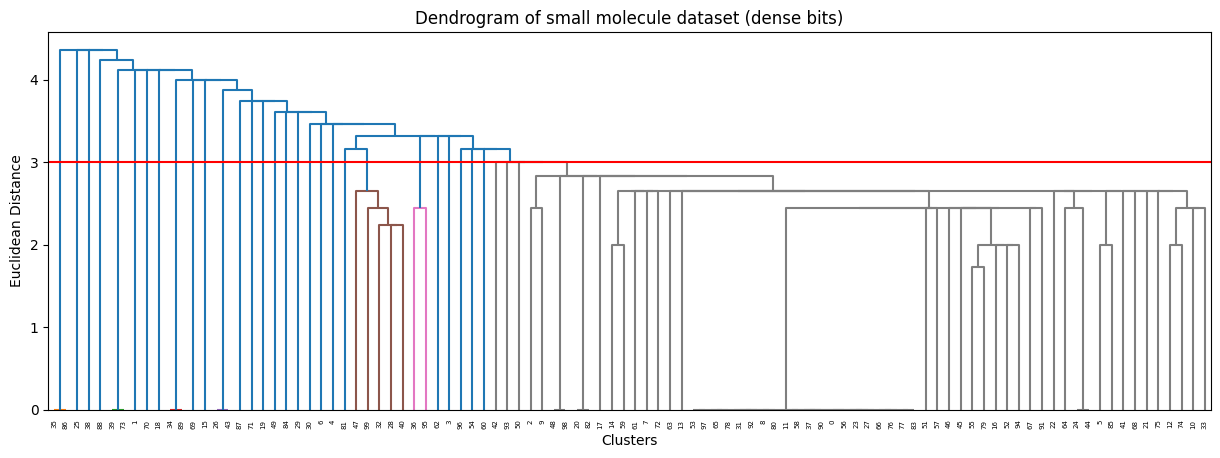

In [102]:
from scipy.cluster import hierarchy
test = algs.HierarchicalClustering(ligand_subset, 
                                          linkage_metric ="single",
                                           distance_metric = "euclidean", 
                                           desired_k = 1).cluster()
plt.figure(figsize =(15, 5))
dn = hierarchy.dendrogram(test.zmat);
plt.title("Dendrogram of small molecule dataset (dense bits)")
plt.xlabel('Clusters')
plt.ylabel('Euclidean Distance')
plt.axhline(y=3, color='r', linestyle='-')
plt.show()

7. Evaluate the quality of both clusterings using your implementation of a clustering quality metric. Explain your choice of quality metric. Which clustering performed ‘best’ according to your metric?

> The quality metric I chose was the silhouette score. The value ranges from -1 to 1. Positive 1 representing great clustering, zero meaning random or poor clustering, and negative 1 meaning clusters are wholy assigned in the wrong way. The score is calcuatled as (b-a)/max(a,b) where (b) is the average inter-cluster distance and (a) is the average intra-cluster distance

> My implementation takes in the initial proximity matrix and the final cluster assignments and calculates both the per-sample score and the total mean score (which is usually reported as the final value). 

> Based on my silhoutte scores, the heirarchial clustering algorithm performed best. However, we know this is total garbage since my scores decided to break last minute.... I'm going to go ahead with the k-means results since visually we know these are performing better. 

In [107]:
sample_scores, total_score = algs.silhouette_score(amanda_hc_clusters.distance_mat, 
                                                   np.fromiter(amanda_hc_clusters.labels.values(), dtype=int))
print(total_score)

sample_scores, total_score = algs.silhouette_score(amanda_pc_clusters_pmat, 
                                                   np.fromiter(amanda_pc_clusters.labels.values(), dtype=int))
print(total_score)

0.009023550900709242
-0.6989635048318162


8. Compare the two clusterings using your implementation of clustering similarity. How similar are the two clusterings using this function?

> The clustering similarity metric I chose is the adjusted Rand Index. This index uses a contigency table to calculate a value representing how often two clusterings of the same values result in the same answer. In this case, the value is also adjusted by the random-chance that two datapoints may fall within the same clusters across the two sets. The ARI generlly takes the form ARI = (index - expected index)/ (max index - expected index). A value of 0 means the clusterings don't match, a value of 1 means they're identical and a negative value means the clusterings less similar than expected by chance. 

> My implementation takes in two numpy arrays that list the cluster assignments of from two different iterations and returns the single ARI value. 

> Based on the ARI, the two clusterings don't remotely match. This is not suprising since my heirarchial clustering is essentially just a random vector apparently. fun stuff. 

In [108]:
ari = algs.adjusted_RandIndex(pc_cluster_assignments, hc_cluster_assignments)
print(ari)

0.04927817025126695


9. For the “best” clustering, as determined by your quality metric, visualize the distribution of Autodock Vina scores in each cluster. Do members of the same cluster have similar docking scores? Why or why not?
> The clusters do not appear to have dramatically different docking score distributions. However, if I was using a larger subset of the data I think this would have been the case. In other iterations I ran, there were large differences. 

In [112]:
final_labels = amanda_pc_clusters.labels
clusters = list(set(val for val in final_labels.values()))


autodoc = []
top2_bycluster = [] #for question 10
for current_cluster in clusters: #for all clusters
    c = []
    members = [k for k,v in final_labels.items() if v == current_cluster]
    for member in members: #for all ligands in cluster
        c.append(float(ligand_dict[member].score)) #make a list of the scores
    autodoc.append(c) #add it to full matrix
    
    #now find the top score for each cluster
    top_ligand = sorted(zip(members,c), key=lambda t: t[1])[2:] #all them together, sorted
    new =  (current_cluster,) + top_ligand[0] #add cluster name to tuple
    top2_bycluster.append(new)
    new =  (current_cluster,) + top_ligand[1]
    top2_bycluster.append(new)
    
#autodoc= [[1, 2, 5,],  [7, 2], [5, 7, 2, 2, 5], [7, 2, 5]] #testing
print("Autodoc structure:", autodoc[0:5])
print("Top Ligands Structure:", top2_bycluster[0:5]) # (cluster number, ligandID, autodoc score)

Autodoc structure: [[-1.3, -1.3, -2.8, -3.1, -2.8, -3.1, -3.5, -2.9, -2.7, -3.5, -3.8, -3.7, -3.5, -2.8, -3.4, -4.2, -3.4, -3.8, -3.9, -4.0, -4.6, -4.3, -3.9, -3.7, -3.3, -3.2, -3.1], [-3.8, -2.8, -2.8, -3.5, -2.3, -3.2, -3.1, -4.0, -3.6, -3.0, -3.4, -3.1, -2.8, -3.9, -3.8, -4.4, -4.3, -4.5, -3.5, -3.9], [-1.7, -1.7, -2.7, -2.7, -2.4, -2.6, -2.9, -2.8, -3.5, -2.9, -2.8, -3.4, -3.2, -3.2, -3.1, -3.7, -4.0, -4.3, -3.5, -3.5, -3.0, -2.6, -3.5, -3.1, -3.2, -3.6, -4.1, -4.0, -4.1, -3.5, -3.2, -3.2, -3.1, -3.9, -3.8, -3.5, -3.4, -3.4, -3.6, -4.0, -3.4, -3.5, -4.0, -3.9, -3.0, -4.5, -3.8, -3.8, -3.5, -3.3, -3.9, -4.0, -3.8]]
Top Ligands Structure: [(0, '79', -4.2), (0, '83', -4.0), (1, '88', -4.3), (1, '43', -4.0), (2, '41', -4.1)]


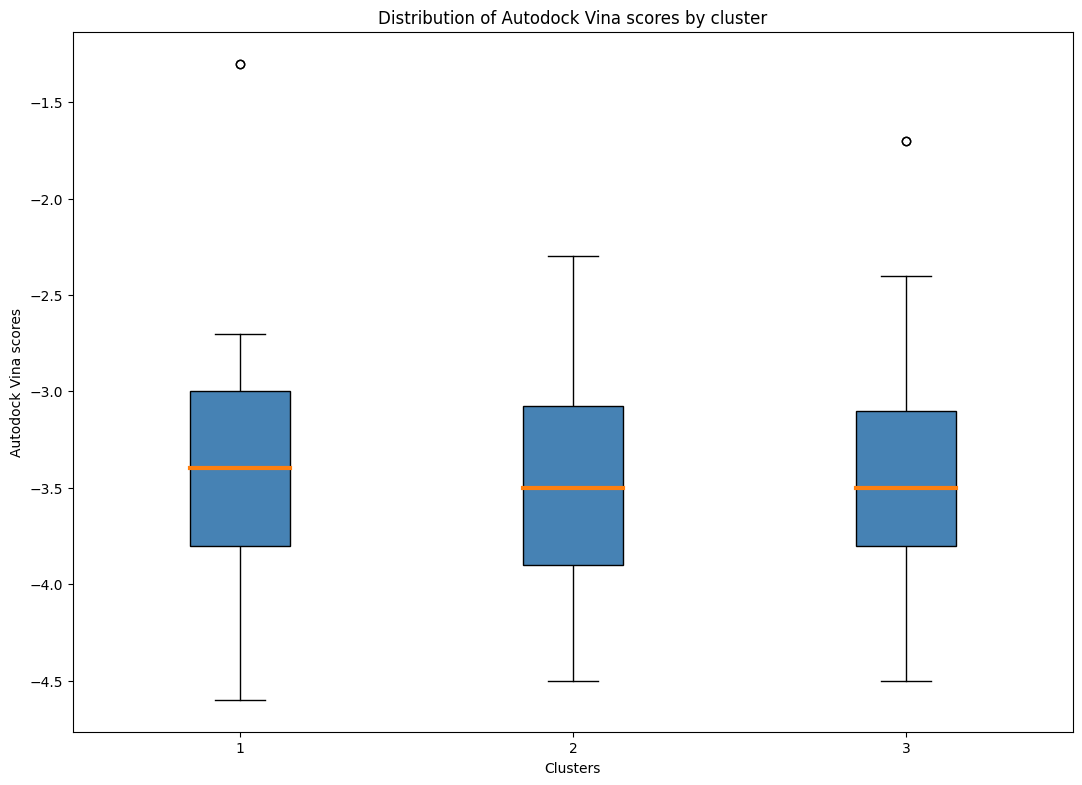

In [113]:
import matplotlib.pyplot as plt 
fig = plt.figure(figsize =(10, 7)) 
ax = fig.add_axes([0, 0, 1, 1])  
bp = ax.boxplot(autodoc, patch_artist=True, 
                boxprops=dict(facecolor='steelblue'), 
                medianprops=dict(linewidth=3)) 
plt.title("Distribution of Autodock Vina scores by cluster") 
plt.xlabel('Clusters')
plt.ylabel('Autodock Vina scores')
plt.show()

10. Select the top scoring molecule from each cluster. This is your list of cluster heads. Visualize the top 5 by score in PyMOL and pick your favorite. Are they structurally diverse?
> With a preface that I am not used to looking at molecule structure so I feel I don't have a good scale for what is 'structually diverse' to begin with, no, I would not say these ligands are structually diverse. The first three look very similar (ring w/ some arms) and the last two look similar to each other. 

In [115]:
# top scoring = most negative.
for i in range(5):
    print("Ligand ID:", top2_bycluster[i][1])

Ligand ID: 79
Ligand ID: 83
Ligand ID: 88
Ligand ID: 43
Ligand ID: 41


## Ligand 79
![MY TITLE](images/image79.png)

## Ligand 83
![MY TITLE](images/image83.png)

## Ligand 88
![MY TITLE](images/image88.png)

## Ligand 43
![MY TITLE](images/image43.png)

## Ligand 41
![MY TITLE](images/image41.png)